# Chapter 5: Define cellular states and make Onco-GPS map

<br>
<div>
    <img src="../media/method_chap4.png" width=2144 height=1041>
</div>

### Analysis overview
Now that we have defined and annotated the 9 KRAS transcriptional components in chapter 3, we will analize their behavior across KRAS mutant cell line samples. 

We will find that in those samples the components clustered into three major groups:

* ERBB3/PI3K – WNT/KRAS Core – AP1 (C1-C3-C9), 
* E2F – MAPK – EMT – MYC (C2-C4-C6-C8) and,
* PAX8/HNF1B – NF-κB (C5-C7).

This suggest that in KRAS mutant cancers the patterns of pathway co-activation, as represented by the components, reflect specific synergies and patterns of cooperation among these pathways. We will use those 3 representative components (C1, C2 and C7), that summarize the transcriptional behavior of the KRAS oncogenic signature genes, to cluster the KRAS mutant samples in the reference dataset using Hierarchical Consensus Clustering ([Monti et al. 2003](http://link.springer.com/article/10.1023/A:1023949509487)) with the Information Coefficient (IC) as similarity metric. This will result in 4 clusters representing cellular states: S1–S4. 

The detailed procedure is as follows:

### Defining Onco-GPS states

*	 Standardize the rows of the  matrix. The standardized values above/below a threshold (3.25/-3.25) are set to that threshold to avoid extreme values. 
*	 Rescale the standardized-thresholded rows of the  matrix to the interval [0, 1]. 
*	 Implement a consensus clustering procedure by bootstrap re-sampling of the columns of the  matrix and by clustering them using hierarchical clustering (Ward agglomeration method, R function hclust) (Hartigan 1975). The pairwise distance between columns of the $H$-matrix is computed using one minus the Information Coefficient (IC).
*	 Repeat the re-sampling 50 times for number-of-clusters/states values between a minimum and maximum and generate a membership matrix for each of the number-of-clusters values.
*	 Compute the cophenetic coefficient of the membership matrices and use it to choose an optimal value  for the number of clusters/states ([Monti et al. 2003](http://link.springer.com/article/10.1023/A:1023949509487))
*	  Generate a final consensus clustering membership table for each of the number-of-clusters values.
*	 Train a multi-class support vector machine (SVM) classifier using as inputs the component amplitudes to predict each of the states (clusters).  This classifier will be useful to assign states to samples from independent test datasets.

To facilitate the visualization and integrated analysis of components, samples and cellular states, we used a novel visualization/analysis paradigm that we call Onco-GPS map. In this map, the transcriptional components are represented by nodes connected by straight lines. In general, the location of these nodes on the map derive from a projection algorithm (Sammon map) that makes the two-dimensional geometric distances between nodes approximate the “informational” distances between the components across the samples (e.g. KRAS mutants) in the reference dataset. In the case of only 3 nodes, as the one we are exemplifying in this notebook, the locations are set to be the nodes of an equilateral triangle (Gibbs or ternary diagram). For an example of the more general case see e.g. notebook 8. 

Once the location of the component nodes is determined, the location of an individual sample can be found by calculating a vectorial sum of the components’ locations weighted by their component amplitudes for that sample. The detailed procedure is as follows:

1.-  **Generating the Onco-GPS layout**. 
* Compute the location of the component nodes by performing a Sammon map projection of the $H$-matrix informational distances from $k_{c}$ to 2-dimensions.  In case of 3 components these can be assigned to the vertices of an equilateral triangle.
*	Plot a black circle symbol and a text label to name the component node.
*	Plot straight lines connecting the component nodes. 
    
2.-  **Projecting samples onto of the Onco-GPS layout**.
* Compute the location for each sample as a vectorial sum of the components’ locations $(C^{j}_{x}, C^{j}_{y})$ weighted by the normalized component amplitudes raised to an exponent $\alpha$

<div>
     <img src="../media/chap5_equation.png" width=450 height=10>
</div>

* This is analogous to calculating the equilibrium location of a mass being pulled by multiple strings, using a physical analogy, or the location of an object by estimating its proximity to a set of reference satellites, using a geographical GPS analogy. In this way, samples with relative high amplitude of a given component, with respect to the rest, will be projected near the location of that dominant component’s node.  
    
    
3.-  **Generating background: contour lines and state-membership colors**.
    The states can be represented using background contour lines and colors in such way that a “region” of the map corresponds to samples sharing the same cellular state membership. The contour represent probabilities of membership to the corresponding state as provided by the state-specific SVM classifiers described above.
    
### 1. Set up notebook and import [CCAL](https://github.com/KwatME/ccal)

In [2]:
from notebook_environment import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

### 2. Read CCLE object and filter H matrix for KRAS mutants

In [4]:
with gzip.open('../data/ccle.pickle.gz') as f:
    CCLE = pickle.load(f)

In [5]:
#kras_mutants = CCLE['Mutation']['df'].columns[CCLE['Mutation']['df'].loc[
    #'KRAS_MUT'].astype(bool)]

h_matrix = pd.read_table('../output/nmfccs_ccle/nmf_k4_h.txt', index_col=0)

h_matrix = h_matrix[[e for e in h_matrix.columns if 'LUNG' in e]]

h_matrix.to_csv('../output/kras_mutant_h_matrix.txt', sep='\t')

h_matrix

,A549_LUNG,ABC1_LUNG,BEN_LUNG,CAL12T_LUNG,CALU1_LUNG,CALU3_LUNG,CALU6_LUNG,CHAGOK1_LUNG,COLO668_LUNG,CORL105_LUNG,...,RERFLCSQ1_LUNG,SBC5_LUNG,SCLC21H_LUNG,SHP77_LUNG,SKMES1_LUNG,SQ1_LUNG,SW1271_LUNG,SW1573_LUNG,SW900_LUNG,T3M10_LUNG
C0,459.571185,2343.564954,6.061238e+03,1231.841006,0.147515,1346.191218,3326.995557,3096.172367,6890.794450,1988.676246,...,39.934926,4039.791853,6350.195931,4214.805582,1202.722279,663.515276,338.204174,323.755000,1514.232404,976.550943
C1,2165.892846,3769.582844,3.570145e+03,4175.644350,1869.366339,5102.991775,1620.643980,3857.366561,2485.912499,3550.571315,...,2317.030738,981.236343,526.893990,777.263925,2777.092193,4837.975100,2441.353515,4164.955677,2582.326767,4717.106124
C2,4546.721848,2744.397207,7.341388e+02,3434.518559,3797.623327,2435.900451,2896.918853,3126.021498,986.389687,1956.119947,...,3507.325720,3464.806426,3890.443526,3959.101430,1202.852406,2481.010097,3770.201873,3184.227609,2400.862778,1959.267774
C3,2970.175705,1207.436019,5.435220e-07,1082.646363,4498.812797,930.781101,2586.602507,16.076202,206.174103,2589.606501,...,4245.218593,2073.625952,0.000244,1641.040294,4972.338900,1825.869238,3557.507705,2198.021748,3687.173612,2200.875697


### 3. Plot KRAS mutant H Matrix

No handles with labels found to put in legend.
No handles with labels found to put in legend.


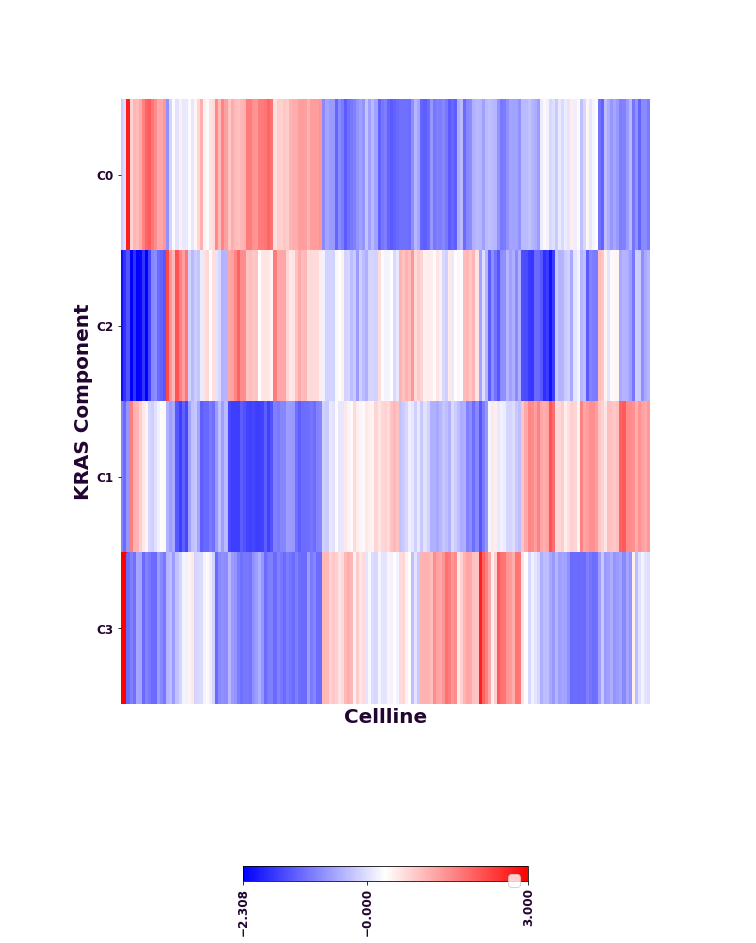

In [6]:
ccal.plot_heatmap(
    h_matrix,
    normalization_method='-0-',
    normalization_axis=1,
    cluster=True,
    xlabel='Cellline',
    ylabel='KRAS Component',
    xticklabels=False)

### 4. Compare the KRAS components to each other

Applying <function compute_information_coefficient at 0x7febce7b6158> ...
	1/4 ...
	4/4 - done.


No handles with labels found to put in legend.


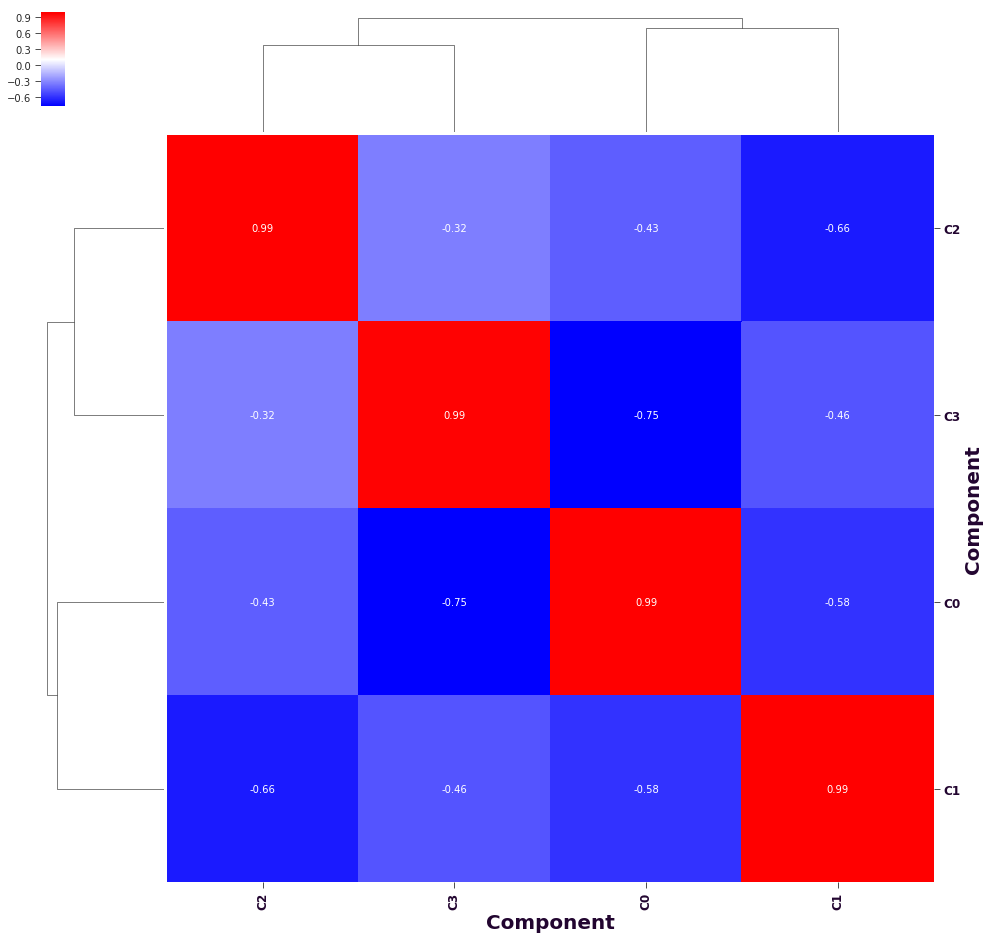

,C0,C1,C2,C3
C0,0.993550,-0.576128,-0.428394,-0.753279
C1,-0.576128,0.987739,-0.662598,-0.463735
C2,-0.428394,-0.662598,0.988897,-0.319541
C3,-0.753279,-0.463735,-0.319541,0.985362


In [7]:
ccal.make_comparison_panel(
    h_matrix,
    h_matrix,
    axis=1,
    array_2d_0_name='Component',
    array_2d_1_name='Component')

### 5. Select components C7, C2 and C1 from KRAS H matrix

In [9]:
#h_matrix = h_matrix.loc[['C7', 'C2', 'C1']]

### 6. Cluster KRAS H matrix to define oncogenic states

Computing distances with <function compute_information_distance at 0x7febc919e950> ...
Applying <function compute_information_distance at 0x7febc919e950> ...
	1/173 ...
	11/173 ...
	21/173 ...
	31/173 ...
	41/173 ...
	51/173 ...
	61/173 ...
	71/173 ...
	81/173 ...
	91/173 ...
	101/173 ...
	111/173 ...
	121/173 ...
	131/173 ...
	141/173 ...
	151/173 ...
	161/173 ...
	171/173 ...
	173/173 - done.


No handles with labels found to put in legend.


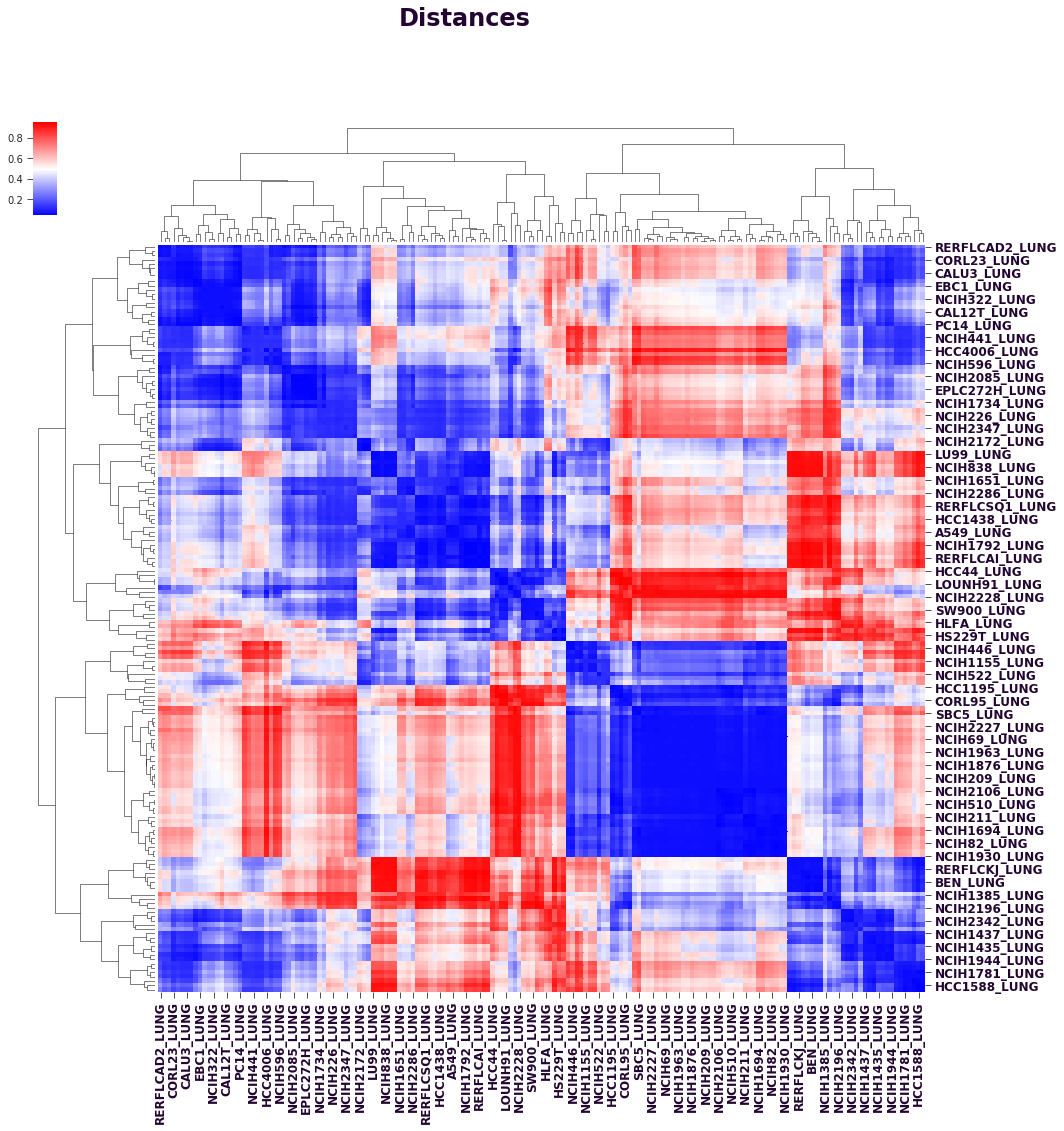

HCC with K = 2 ...
	K = 2: 1/50 ...
	K = 2: 11/50 ...
	K = 2: 21/50 ...
	K = 2: 31/50 ...
	K = 2: 41/50 ...
	K = 2: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


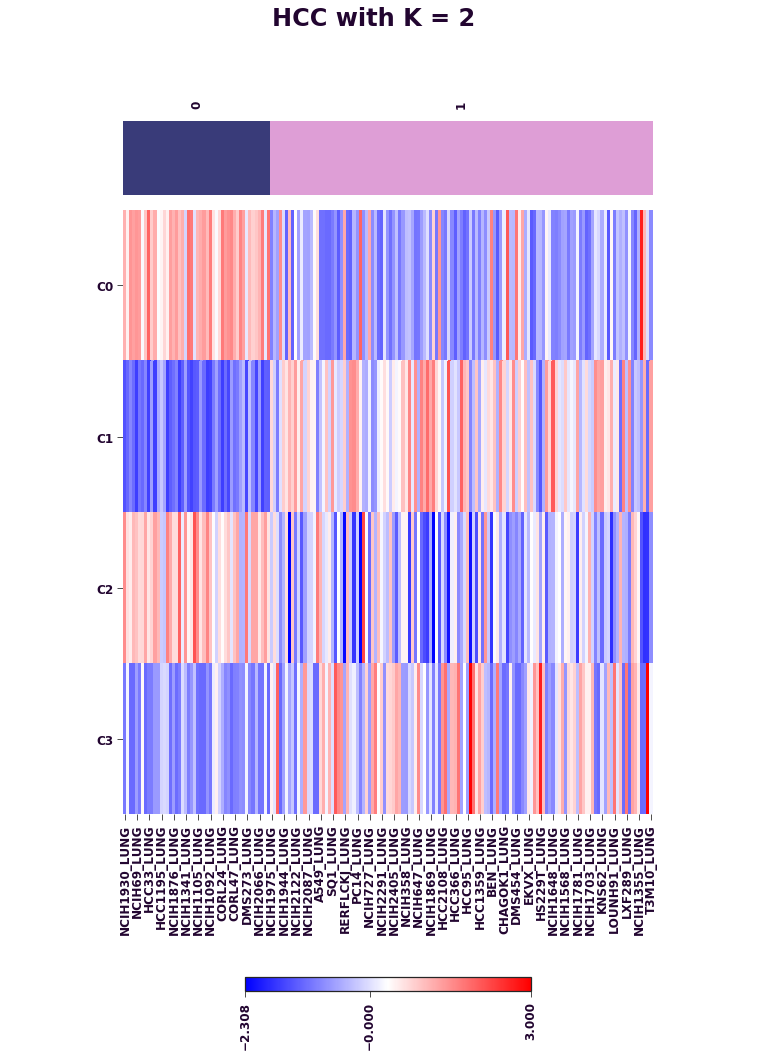

No handles with labels found to put in legend.
No handles with labels found to put in legend.


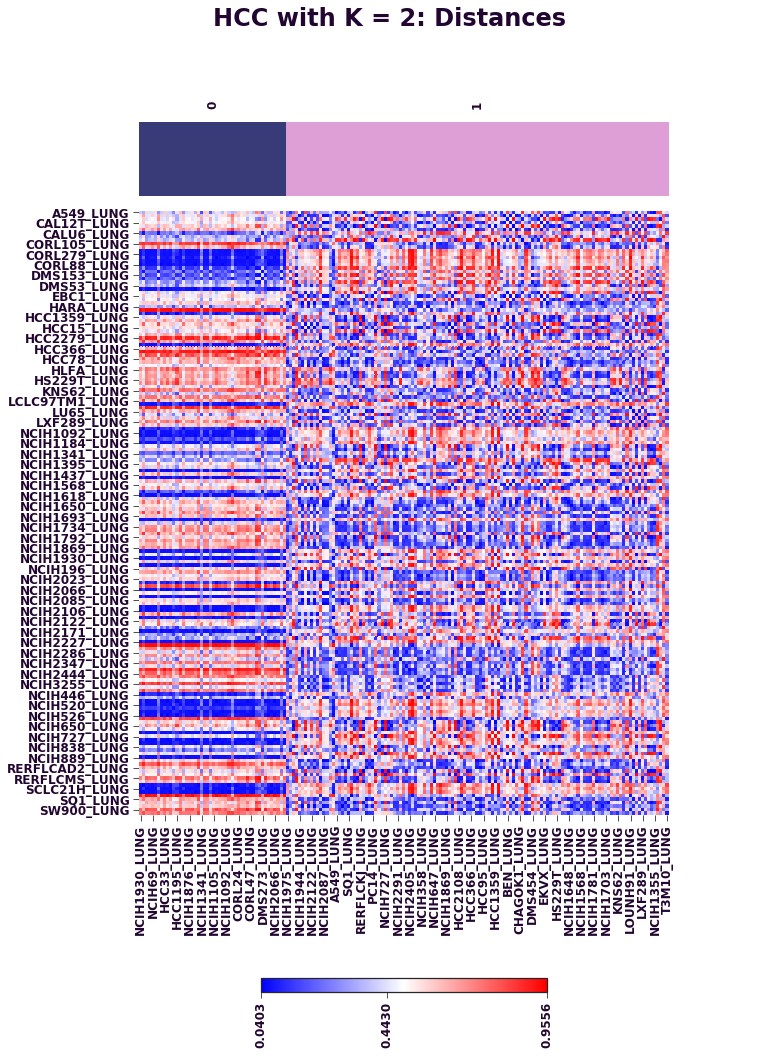

HCC with K = 3 ...
	K = 3: 1/50 ...
	K = 3: 11/50 ...
	K = 3: 21/50 ...
	K = 3: 31/50 ...
	K = 3: 41/50 ...
	K = 3: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


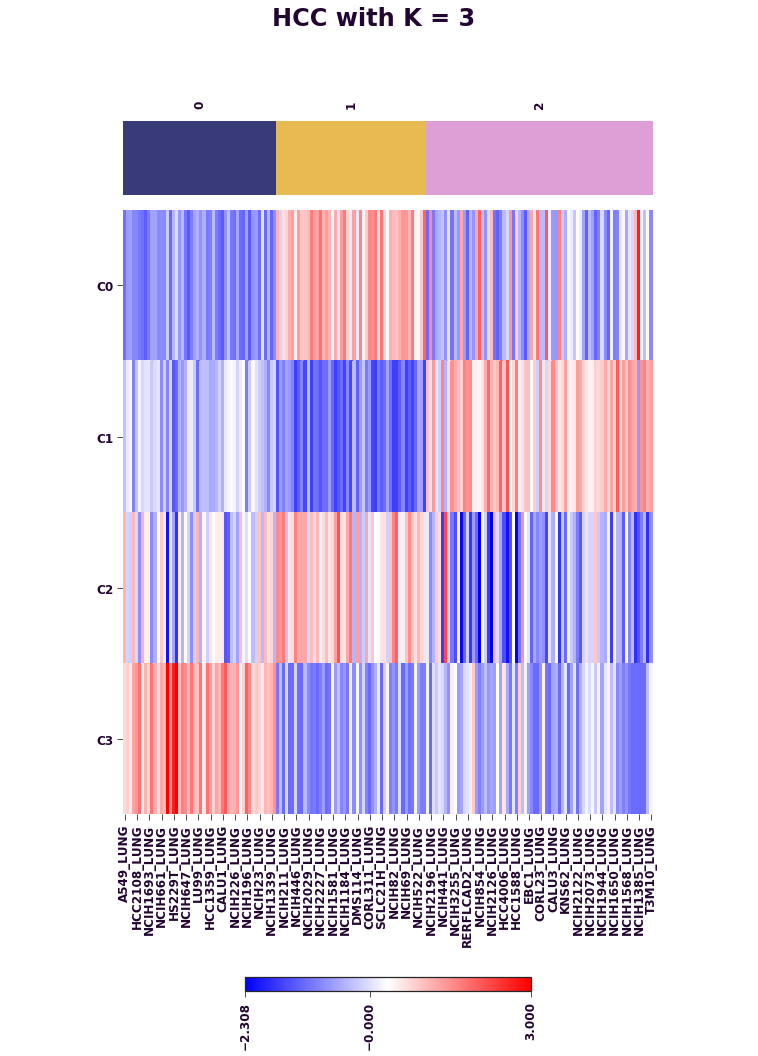

No handles with labels found to put in legend.
No handles with labels found to put in legend.


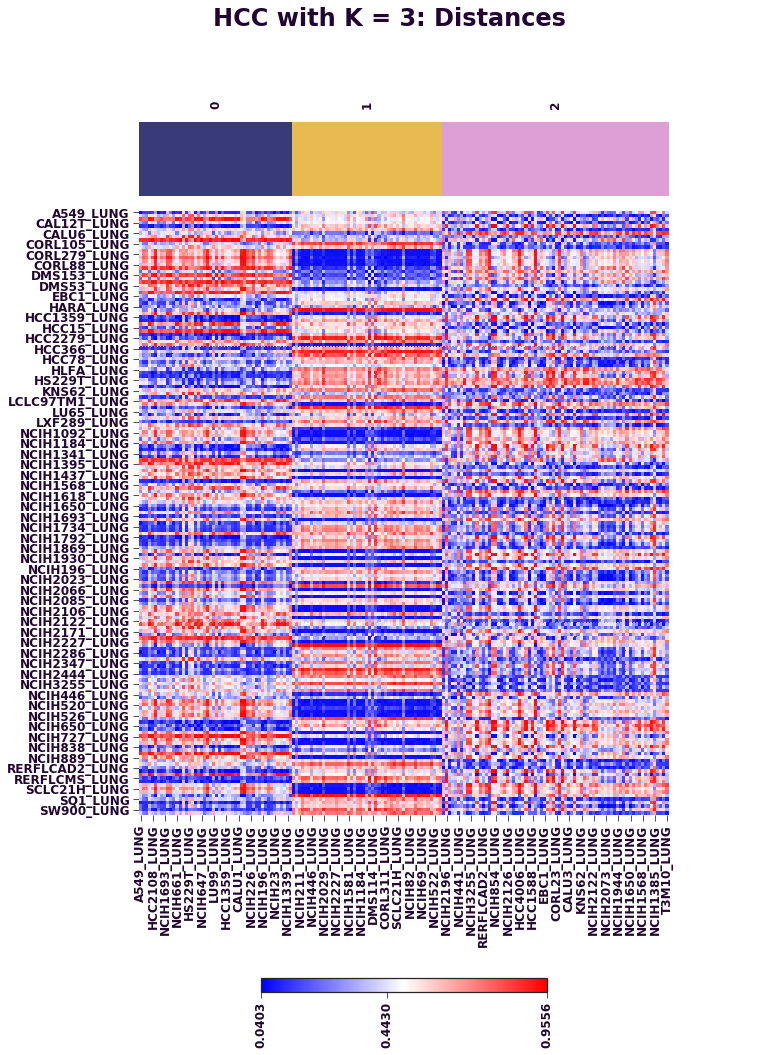

HCC with K = 4 ...
	K = 4: 1/50 ...
	K = 4: 11/50 ...
	K = 4: 21/50 ...
	K = 4: 31/50 ...
	K = 4: 41/50 ...
	K = 4: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


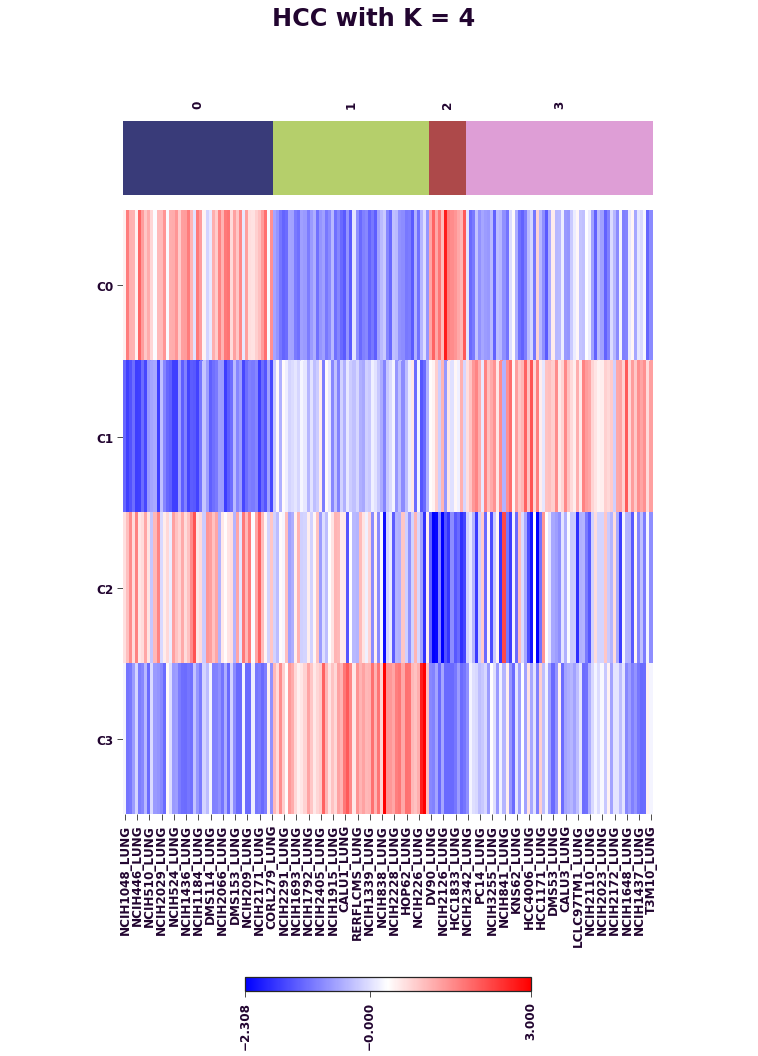

No handles with labels found to put in legend.
No handles with labels found to put in legend.


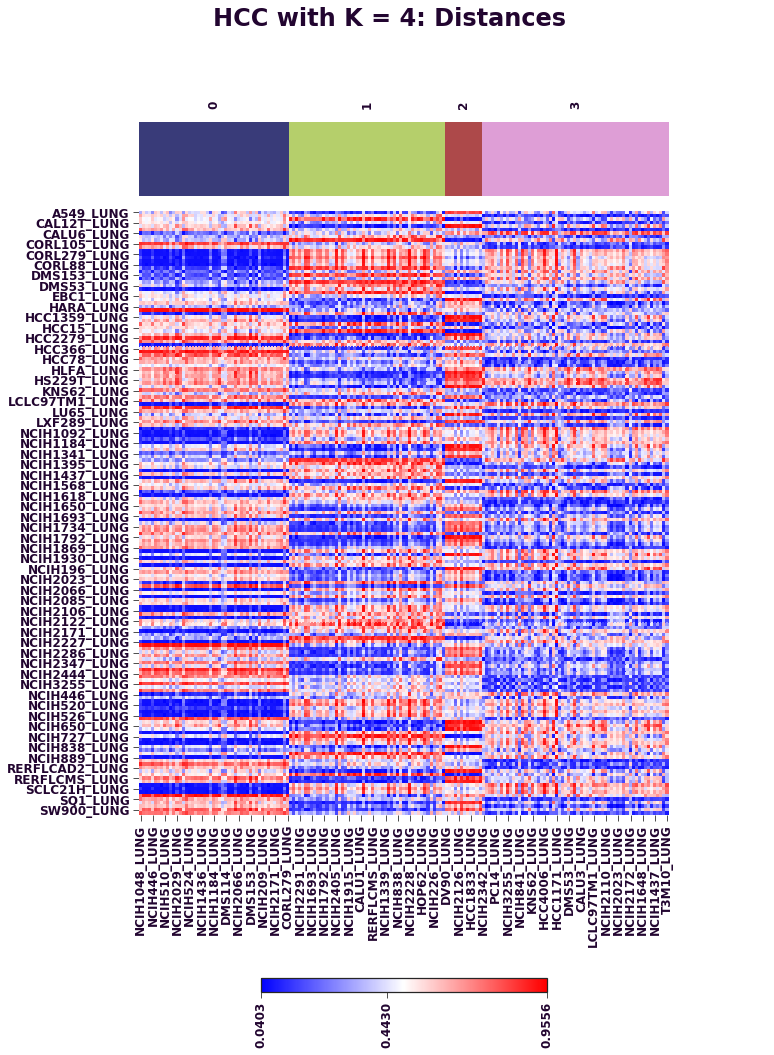

HCC with K = 5 ...
	K = 5: 1/50 ...
	K = 5: 11/50 ...
	K = 5: 21/50 ...
	K = 5: 31/50 ...
	K = 5: 41/50 ...
	K = 5: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


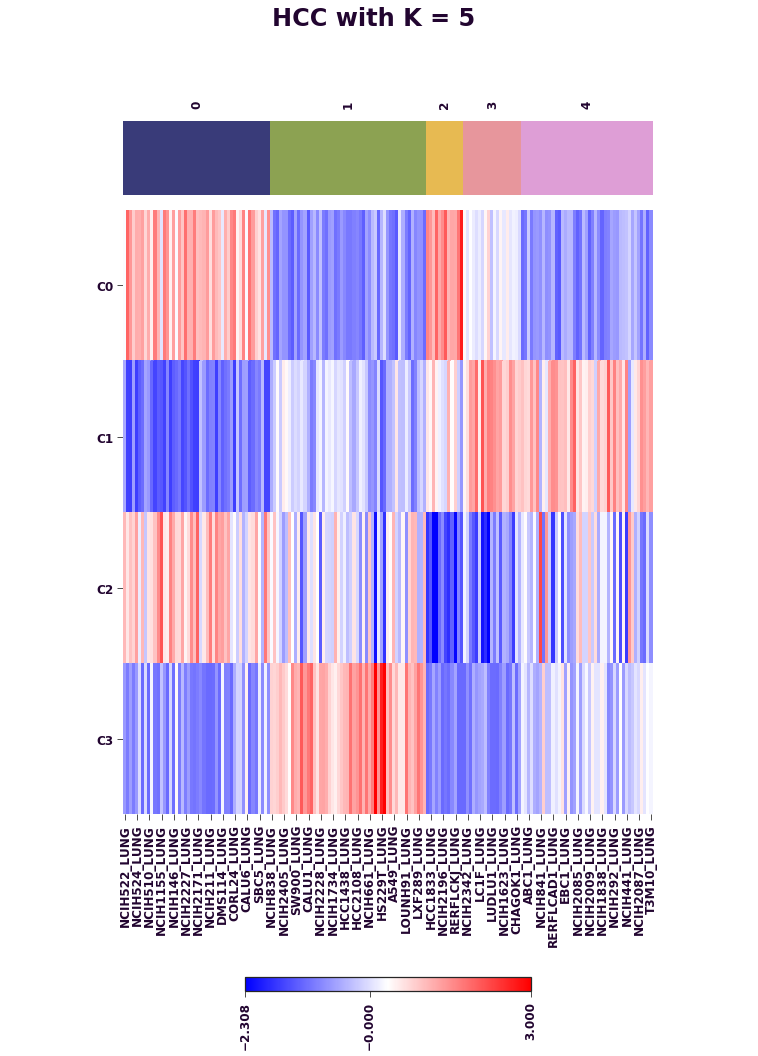

No handles with labels found to put in legend.
No handles with labels found to put in legend.


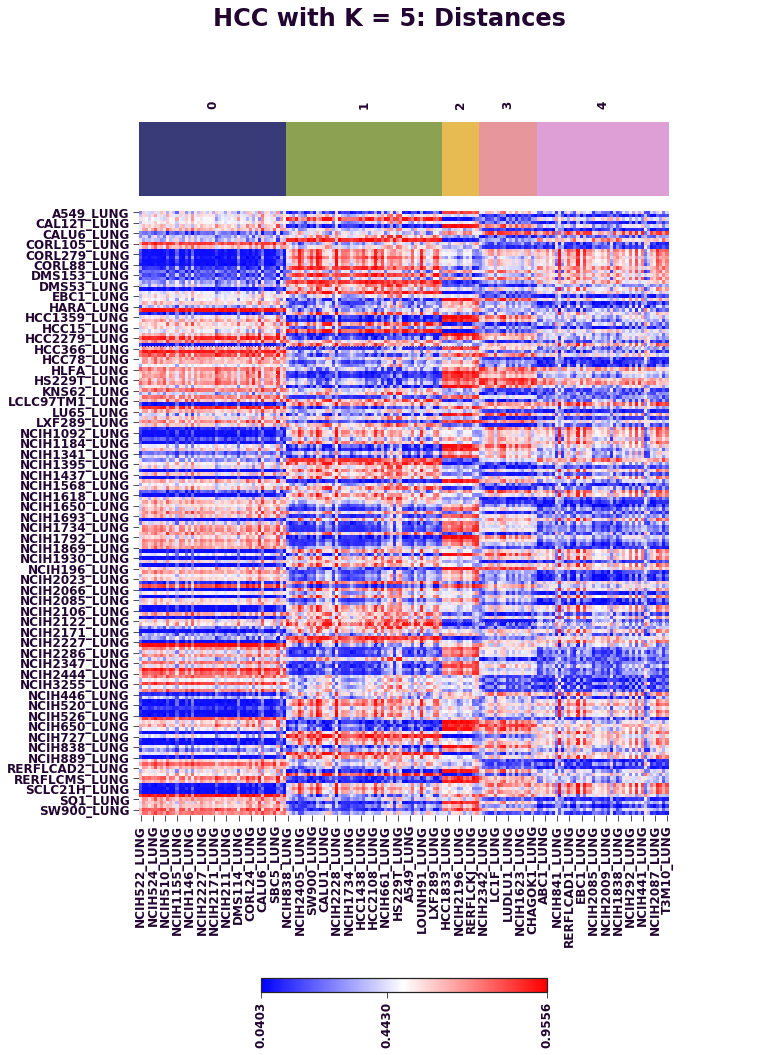

HCC with K = 6 ...
	K = 6: 1/50 ...
	K = 6: 11/50 ...
	K = 6: 21/50 ...
	K = 6: 31/50 ...
	K = 6: 41/50 ...
	K = 6: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


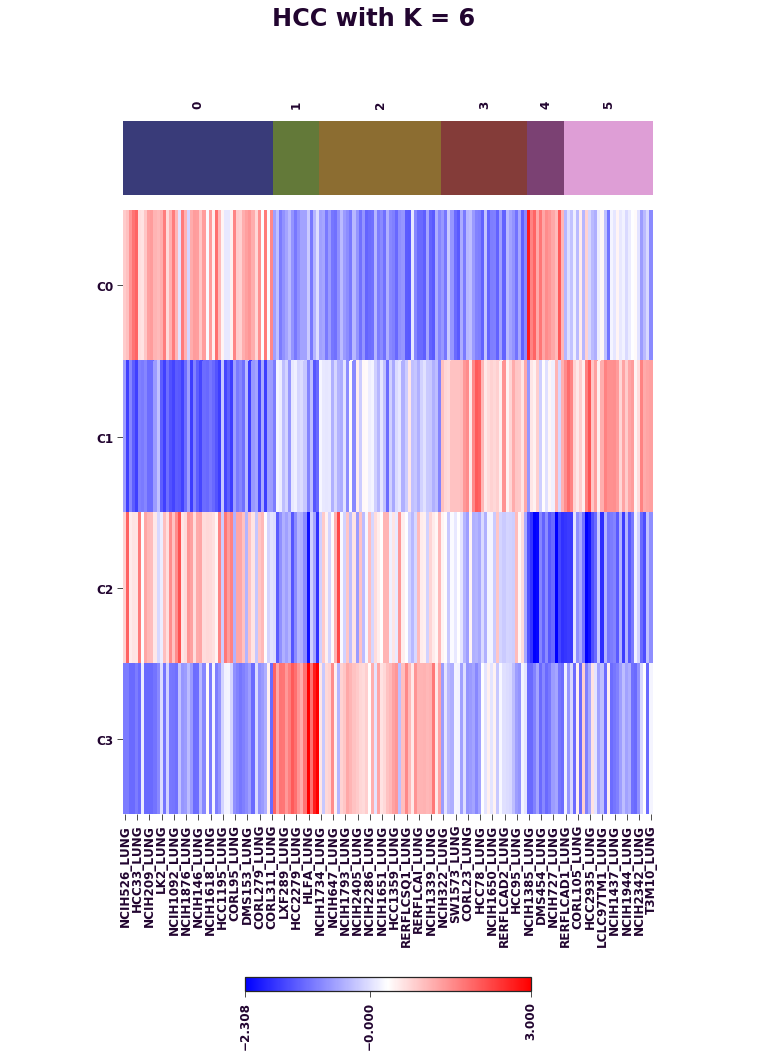

No handles with labels found to put in legend.
No handles with labels found to put in legend.


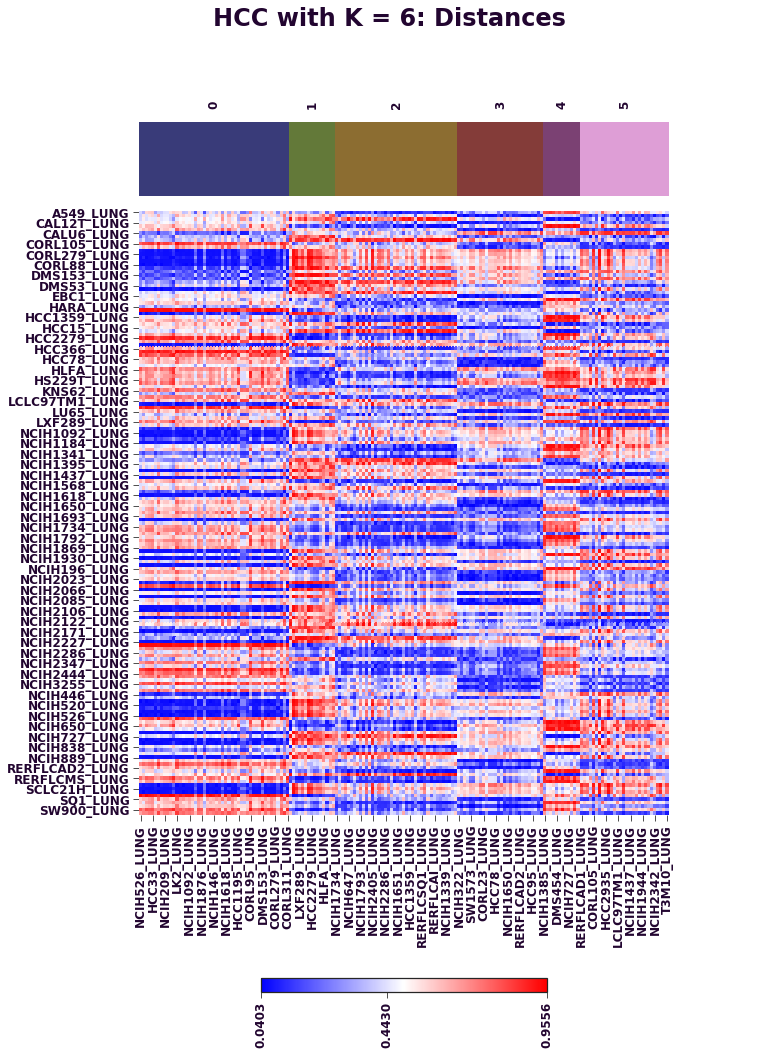

HCC with K = 7 ...
	K = 7: 1/50 ...
	K = 7: 11/50 ...
	K = 7: 21/50 ...
	K = 7: 31/50 ...
	K = 7: 41/50 ...
	K = 7: 50/50 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


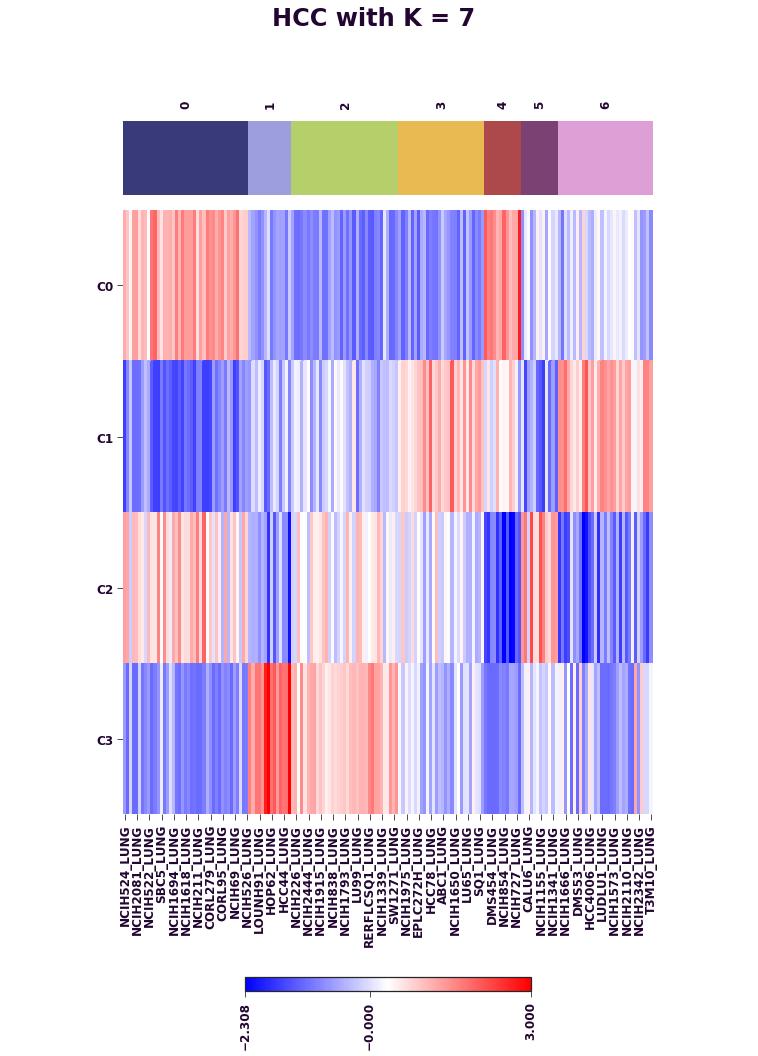

No handles with labels found to put in legend.
No handles with labels found to put in legend.


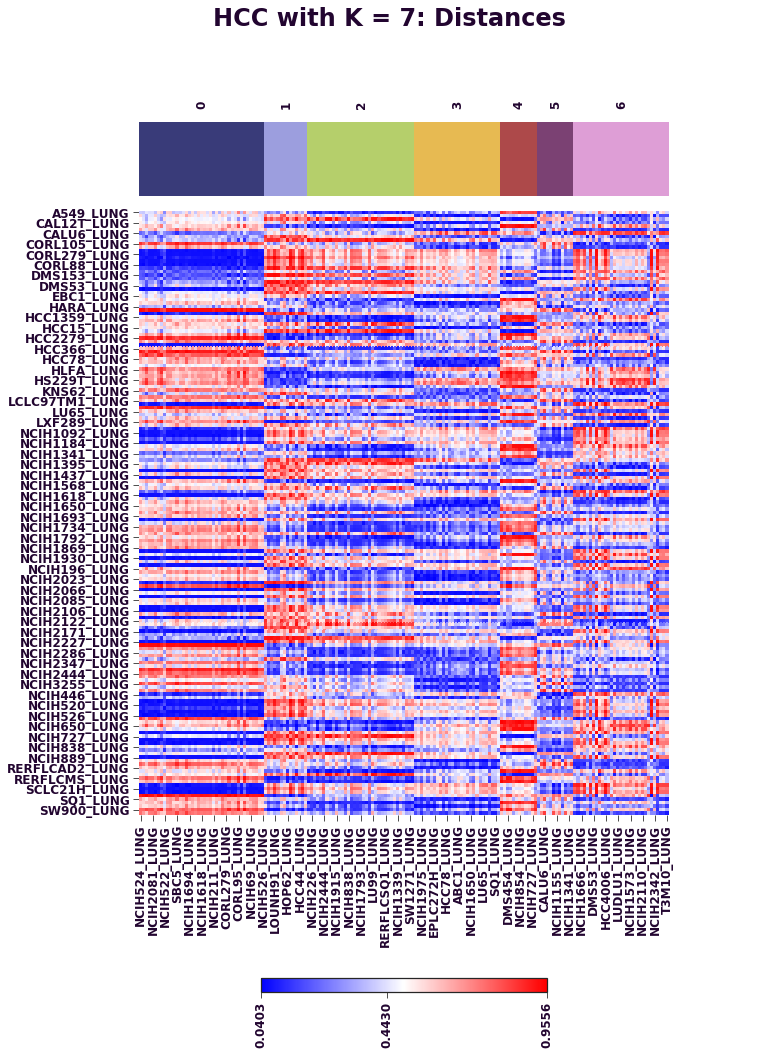

No handles with labels found to put in legend.


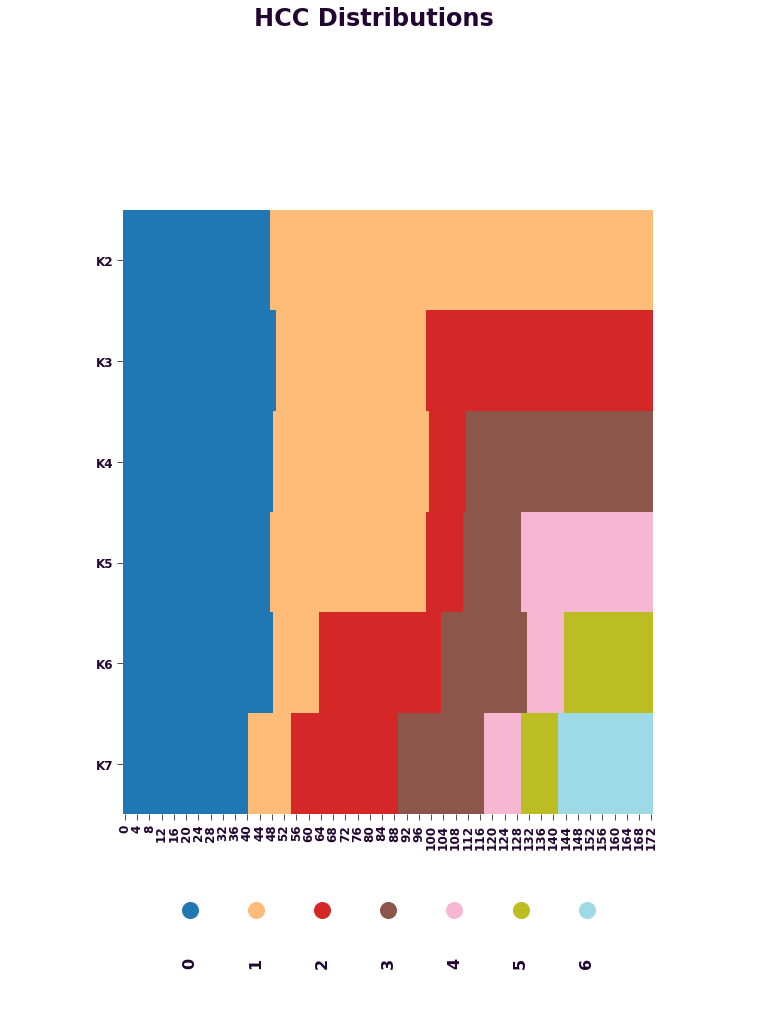

No handles with labels found to put in legend.


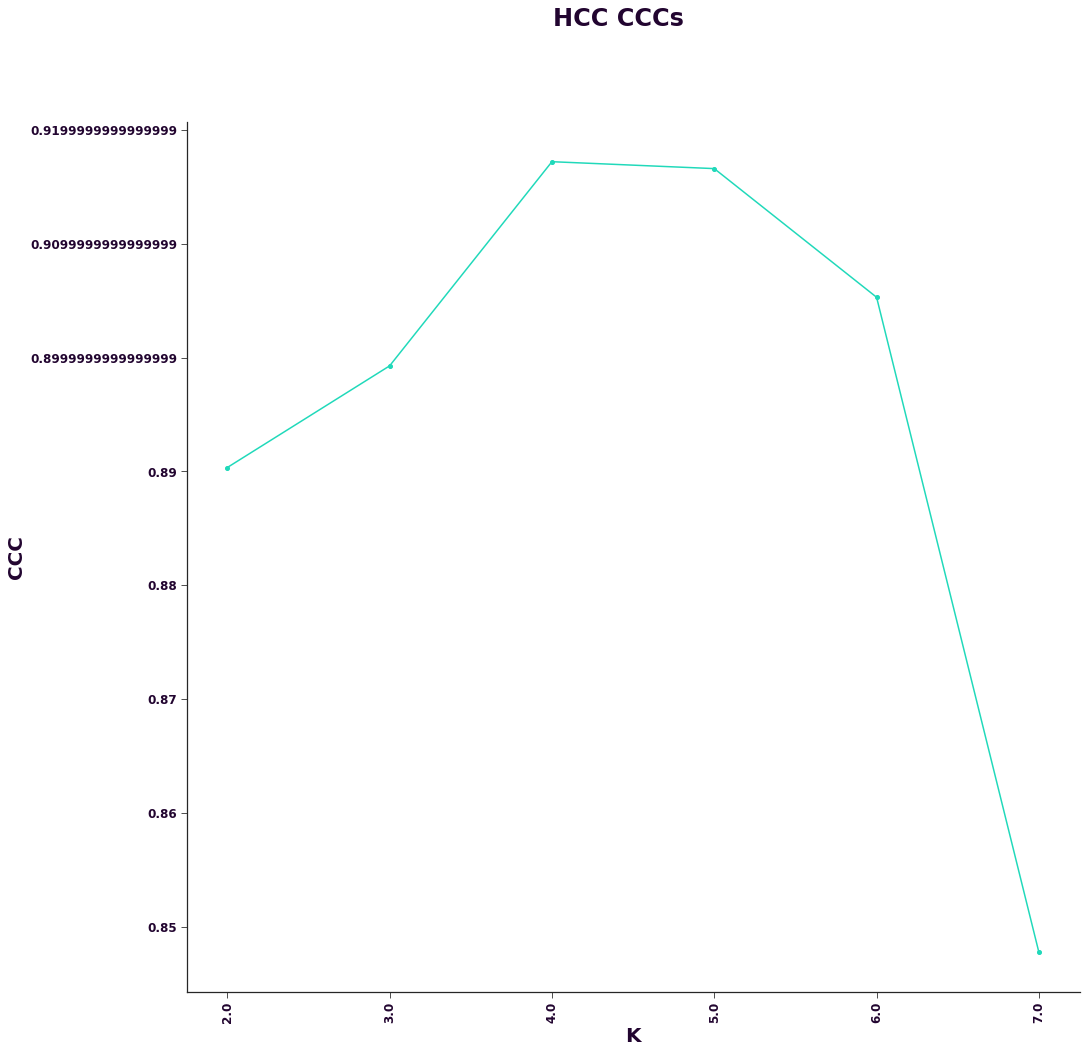

In [8]:
# '-0-' normalize each row
a = ccal.normalize_2d_array(h_matrix.values, '-0-', axis=1)

# Clip values 3 standard deviation away from each row
a = a.clip(min=-3, max=3)

# '0-1' normalize each row
a = ccal.normalize_2d_array(a, '0-1', axis=1)

h_matrix = pd.DataFrame(a, index=h_matrix.index, columns=h_matrix.columns)

ds, hcs, hccs, cccs = ccal.define_states(
     h_matrix,
     range(2, 8),
     '../output/hccs_ccle_lung',
     n_clusterings=50,
     random_seed=12765)

### 7. Rename onocgenic states to match article

In [9]:
hccs = pd.read_table('../output/hccs_ccle_lung/hccs.txt', index_col=0)

sample_states = hccs.loc['K4']

sample_states.name = 'State'

sample_states.index.name = 'Cellline'
sample_states.name = 'KRAS Mutant Sample State'

sample_states.to_csv(
    '../output/kras_mutant_sample_states.txt', sep='\t', header=True)

# Rename states to match the paper
sample_states = sample_states.map({2: 0, 3: 1, 0: 2, 1: 3})
sample_states

Cellline
A549_LUNG         3
ABC1_LUNG         1
BEN_LUNG          0
CAL12T_LUNG       1
CALU1_LUNG        3
CALU3_LUNG        1
CALU6_LUNG        2
CHAGOK1_LUNG      1
COLO668_LUNG      0
CORL105_LUNG      1
CORL23_LUNG       1
CORL24_LUNG       2
CORL279_LUNG      2
CORL311_LUNG      2
CORL47_LUNG       2
CORL88_LUNG       2
CORL95_LUNG       2
DMS114_LUNG       2
DMS153_LUNG       2
DMS273_LUNG       2
DMS454_LUNG       0
DMS53_LUNG        1
DMS79_LUNG        2
DV90_LUNG         0
EBC1_LUNG         1
EKVX_LUNG         3
EPLC272H_LUNG     1
HARA_LUNG         1
HCC1171_LUNG      1
HCC1195_LUNG      2
                 ..
NCIH524_LUNG      2
NCIH526_LUNG      2
NCIH596_LUNG      1
NCIH647_LUNG      3
NCIH650_LUNG      3
NCIH661_LUNG      3
NCIH69_LUNG       2
NCIH727_LUNG      0
NCIH810_LUNG      2
NCIH82_LUNG       2
NCIH838_LUNG      3
NCIH841_LUNG      1
NCIH854_LUNG      0
NCIH889_LUNG      2
PC14_LUNG         1
RERFLCAD1_LUNG    1
RERFLCAD2_LUNG    1
RERFLCAI_LUNG     3
RERFLCKJ_LU

### 8. Produce heatmap of KRAS mutant samples and their membership in each state
This is the top of Fig 6A in the article.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


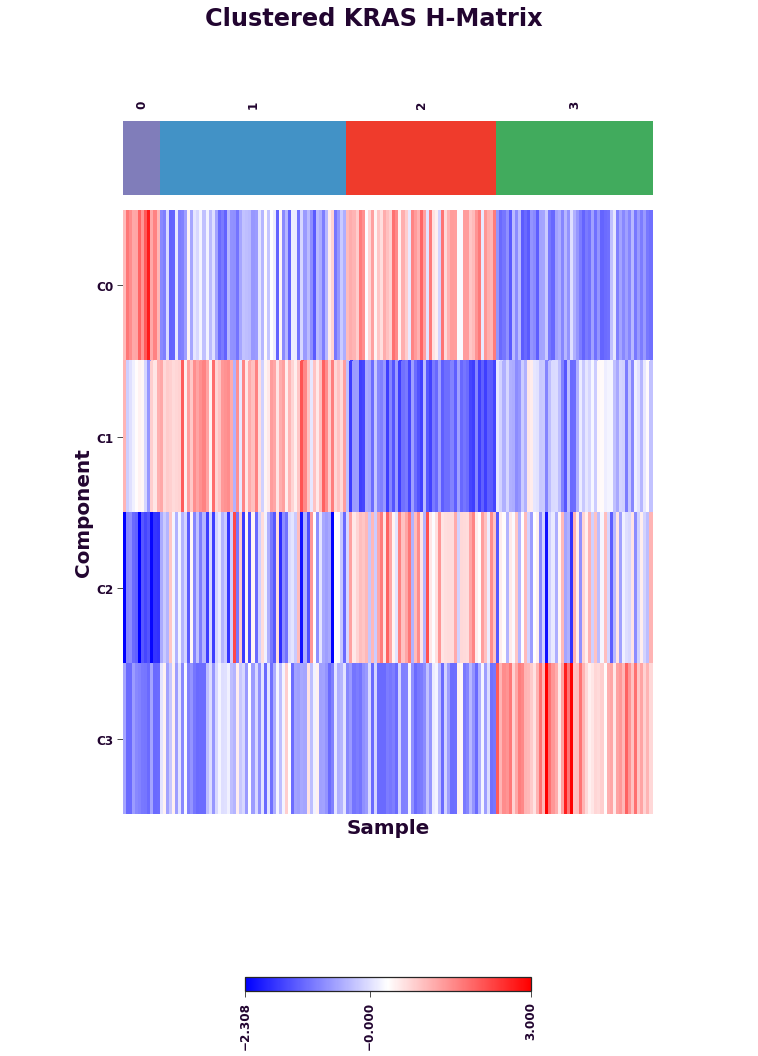

In [10]:
PURPLE = '#807DBA'
BLUE = '#4292C6'
GREEN = '#41AB5D'
RED = '#EF3B2C'

ccal.plot_heatmap(
    h_matrix,
    data_type='continuous',
    normalization_method='-0-',
    normalization_axis=1,
    column_annotation=sample_states,
    annotation_colors=[PURPLE, BLUE, RED, GREEN],
    title='Clustered KRAS H-Matrix',
    xlabel='Sample',
    ylabel='Component',
    xticklabels=False)

### 9. Generate the KRAS mut Onco-GPS map 
This is the bottom of Fig 6A in the article.

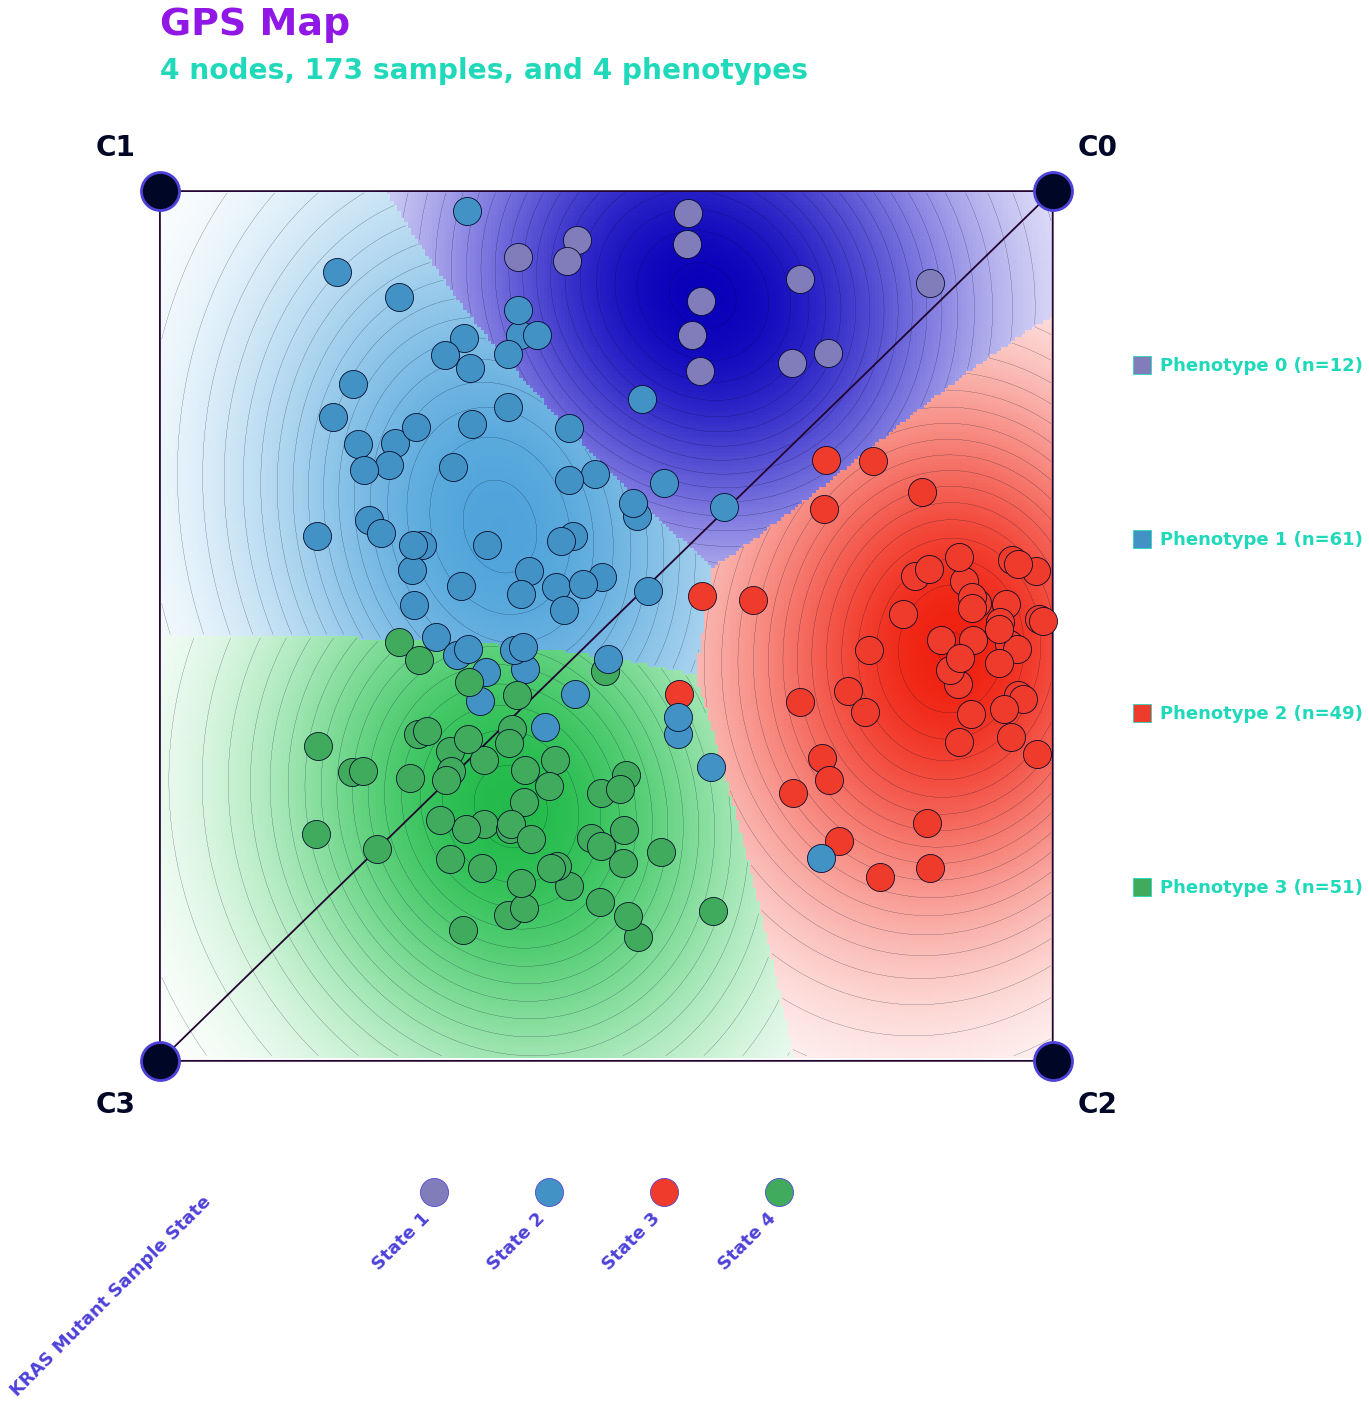

In [11]:
gps_map = ccal.GPSMap(
    h_matrix,
    pull_power=1.2,
    node_x_dimension=pd.DataFrame(
        [[1,1], [0,1], [1, 0], [0, 0]], index=h_matrix.index))

gps_map.set_sample_phenotypes(
    sample_states,
    phenotype_type='categorical',
    bandwidth_factor=2.8,
    phenotype_color_map=mpl.colors.ListedColormap([PURPLE, BLUE, RED, GREEN]),
    phenotype_to_str={i: 'State {}'.format(i + 1)
                      for i in range(4)})

gps_map.plot_samples_with_phenotype()

# gps_map.save('../output/kras_mutant_gps_map.pickle.gz')

### [Next chapter (6)](6 Annotate cellular states.ipynb)